# Analyse descriptive des dons

### Todo : 
Analyse d’ensemble
- quels sont les volumes de dons, 
- différence entre H et F
- les étrangers font-il des dons
- quels sont les domaines des dons?
- distribution des dons en fonction des domaines, et comparaison avec la distribution des œuvres achetées et commandées 

Sur la circulation ultérieure des œuvres données :
- on ne peut travailler que sur les expos qui sont listées dans videomuseum, mais nous n’avons pas besoin de nettoyer ce champs dans la mesure où ce que nous cherchons c’est un compte de mouvements plutôt qu’une caractérisation précise du lieu et du type de musées où elle bouge (et on oublie aussi avec qui elle bouge)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import re
import unicodedata
# %matplotlib inline

In [2]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
global color_h, color_f, color_b, PLOTDIM, FREQYEARS
color_h = "gold"
color_f = "royalblue"
color_b = "dimgray"
color_t = "mediumseagreen"
PLOTDIM = (9,6)
FREQYEARS = 10
my_cm = LinearSegmentedColormap.from_list("colormap", [color_h, color_f], N=100)

In [3]:
matplotlib.font_manager._rebuild()
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['font.sans-serif'] = 'Roboto'
plt.rcParams['font.weight'] = 500
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [4]:
# Les données sont stockées dans le dossier "data", c'est plus clean
authors = pd.read_csv('../data/ALL_AUTHORS (live_work + clean nat).csv', encoding='utf-8', sep=',', low_memory=False)
raw_art = pd.read_csv('../data/ALL_ARTWORKS (for stats use ONLY).csv', encoding='utf-8', sep=',', low_memory=False)
raw_art['groupcol'] = raw_art['related'].fillna(value='') + raw_art['acquisition'].fillna(value='')
len(raw_art[raw_art['groupcol'] == ''])

21

In [5]:
# On fusionne les "séries"
art = raw_art.groupby(['groupcol', 'authors', 'acquisition_year', 'acquisition_mode_clean']).first().reset_index()
print(raw_art.shape, art.shape)

(348333, 117) (120902, 117)


In [6]:
def validname(value):
    """
    Normalizes string, converts to lowercase, removes non-alpha characters,
    and converts spaces to hyphens.
    """
    value = re.sub('[^\w\s-]', '', value).strip().lower()
    value = re.sub('[-\s]+', '-', value)
    return value

### Etape préliminaire 1 : transformer les modes d'acquisitions

In [7]:
art.loc[art["acquisition_mode_clean"].str.contains("Don "), 'acquisition_mode_clean'] = "Don"
art.loc[art["acquisition_mode_clean"].str.contains("commande"), 'acquisition_mode_clean'] = "Commande"
art.loc[art["acquisition_mode_clean"].str.contains("Commande"), 'acquisition_mode_clean'] = "Commande"
art.loc[art["acquisition_mode_clean"].str.contains("Saisie"), 'acquisition_mode_clean'] = "Saisie"
art.loc[art["acquisition_mode_clean"].str.contains("renseigné"), 'acquisition_mode_clean'] = "Non renseigné"
art.loc[art["acquisition_mode_clean"].str.contains("mixte"), 'acquisition_mode_clean'] = "Mixte"
art.loc[art["acquisition_mode_clean"].str.contains("sinistre"), 'acquisition_mode_clean'] = "Remplacement"

### Etape préliminaire 2 : transformer les domaines

In [8]:
art.loc[art["domain"] == "Arts du spectacle", 'domain'] = "Spectacle, musique, littérature"
art.loc[art["domain"] == "Performance", 'domain'] = "Spectacle, musique, littérature"
art.loc[art["domain"] == "Musique", 'domain'] = "Spectacle, musique, littérature"
art.loc[art["domain"] == "Littérature", 'domain'] = "Spectacle, musique, littérature"

art.loc[art["domain"] == "Commande publique (A.D.D.)", 'domain'] = "Divers"
art.loc[art["domain"] == "Design couleur", 'domain'] = "Divers"
art.loc[art["domain"] == "Commande publique (A.P.)", 'domain'] = "Divers"
art.loc[art["domain"] == "Oeuvre olfactive", 'domain'] = "Divers"
art.loc[art["domain"] == "Domaine mixte, voir détail sur les éléments", 'domain'] = "Divers"
art.loc[art["domain"] == "Domaine non saisi", 'domain'] = "Divers"
art.loc[art["domain"] == "Sans domaine déterminé", 'domain'] = "Divers"
art.loc[art["domain"] == "Certificat", 'domain'] = "Divers"
art.loc[art["domain"] == "Architecture intérieure", 'domain'] = "Divers"
art.loc[art["domain"] == "Spectacle, musique, littérature", 'domain'] = "Divers"

art.loc[art["domain"] == "Objet", 'domain'] = "Objet/Design"

art.loc[art["domain"] == "Oeuvre en 3 dimensions", 'domain'] = "Œuvre en 3D"
art.loc[art["domain"] == "Oeuvre textile", 'domain'] = "Œuvre textile"
art.loc[art["domain"] == "Reproduction photomécanique", 'domain'] = "Repro. photomécanique"
art.loc[art["domain"] == "Publication, livre, reliure", 'domain'] = "Arts du livre"

### Etape préliminaire 3 : "donner un genre" aux oeuvres

In [9]:
art['Gender'].value_counts()

masculin         95888
féminin          19282
groupe            2728
non renseigné     1439
Name: Gender, dtype: int64

In [10]:
art['Gender'].count()/len(art) # 4,4% de NaN

0.9870556318340474

### Etape préliminaire 4 : créer les regroupements de collection

In [11]:
fracs, musées, autres = [], [], []
for museum in art['collection'].dropna().unique():
    if "frac" in museum.lower():
        fracs.append(museum)
    elif "musée" in museum.lower() and "musée national d'art moderne" not in museum.lower():
        musées.append(museum)
    elif ("musée national d'art moderne" not in museum.lower() and
          "centre national des arts plastiques" not in museum.lower()):
        autres.append(museum)
len(fracs), len(musées), len(autres)

(18, 33, 5)

In [12]:
cat_dons = ['Don', 'Donation', 'Dation', 'Legs']

In [13]:
art["acquisition_mode_clean"].value_counts()

Achat                         76030
Don                           18307
Commande                      13379
Donation                       4414
Attribution                    3295
Legs                           1952
Non renseigné                  1757
Dation                         1144
Dépôt                           281
Inscription à l'inventaire      247
Mixte                            34
Saisie                           24
Echange                          19
Remplacement                     13
Cession                           6
Name: acquisition_mode_clean, dtype: int64

### Etape préliminaire 5 : compter les expositions

In [14]:
art['nb_expos'] = art['expositions'].str.split('|').dropna().apply(len)
art['nb_expos'] = art['nb_expos'].fillna(0)

In [15]:
raw_art = raw_art.set_index('_id')

In [16]:
authors['unique_mode'] = None
for i, a in authors.iterrows():
    y = a['ID artworks'].split('|')
    if len(y) == 1:
        if (raw_art.index == int(y[0])).any():
            x = raw_art[raw_art.index == int(y[0])]
            authors.loc[i, 'unique_mode'] = x['acquisition_mode_clean'].values
            authors.loc[i, 'unique_domain'] = x['domain'].values
            authors.loc[i, 'unique_age'] = x['acquisition_year'].values - a['Birth year']

## Partie 1 : Compte brut du nombre de noms

In [17]:
def compte_brut_dons(art):
    art = art[(art['acquisition_year'] >= 1945) & (art['acquisition_year'] <= 2017)]
    dons = art[art['acquisition_mode_clean'].isin(cat_dons)]
    
    total = art.groupby('acquisition_year').count()['_id']
    total_dons = dons.groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    femmes_dons = dons[dons['Gender']=='féminin'].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    hommes_dons = dons[dons['Gender']=='masculin'].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    
    fig, ax = plt.subplots()
    femmes_dons.plot(figsize=PLOTDIM, color=color_f, marker='.', linewidth=2, ax=ax)
    hommes_dons.plot(figsize=PLOTDIM, color=color_h, marker='.', linewidth=2, ax=ax)
    total.plot(figsize=PLOTDIM, color=color_b, marker='.', linewidth=2, ax=ax)
    total_dons.plot(figsize=PLOTDIM, color=color_t, marker='.', linewidth=2, ax=ax)
    ax.set_xlim(left = 1945,right = 2017)
    # ax.set_ylim(bottom = -0.01,top = 1.01)
    ax.tick_params(labelsize = 15)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(FREQYEARS))
    ax.set_xlabel('')
    # ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    plt.grid()
    plt.savefig("compte_brut_dons.png", bbox_inches='tight',format="png", dpi=300, transparent=True)
    plt.close()

In [18]:
compte_brut_dons(art)

## Partie 2 : Compte relatif du nombre de dons

In [19]:
def compte_relatif_dons(art):
    art = art[(art['acquisition_year'] >= 1945) & (art['acquisition_year'] <= 2017)]
    dons = art[art['acquisition_mode_clean'].isin(cat_dons)]
    
    total = art.groupby('acquisition_year').count()['_id']
    total_dons = dons.groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    femmes_dons = dons[dons['Gender']=='féminin'].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    hommes_dons = dons[dons['Gender']=='masculin'].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    
    r1 = total_dons/total
    rf = femmes_dons/total_dons
    rh = hommes_dons/total_dons
    
    fig, ax = plt.subplots()
    rf.plot(figsize=PLOTDIM, color=color_f, marker='.', linewidth=2, ax=ax)
    rh.plot(figsize=PLOTDIM, color=color_h, marker='.', linewidth=2, ax=ax)
    r1.plot(figsize=PLOTDIM, color=color_t, marker='.', linewidth=2, ax=ax)
    
    ax.set_xlim(left = 1945,right = 2017)
    ax.set_ylim(bottom = -0.01,top = 1.01)
    ax.tick_params(labelsize = 15)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(FREQYEARS))
    ax.set_xlabel('')
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    plt.grid()
    plt.savefig("compte_relatif_dons.png", bbox_inches='tight',format="png", dpi=300, transparent=True)
    plt.close()

In [20]:
compte_relatif_dons(art)

## Partie 3 : proportions de dons, hommes et femmes

In [21]:
def proportions_genre_dons(art):
    art = art[(art['acquisition_year'] >= 1945) & (art['acquisition_year'] <= 2017)]
    dons = art[art['acquisition_mode_clean'].isin(cat_dons)]

    femmes_total = art[art['Gender']=='féminin'].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    hommes_total = art[art['Gender']=='masculin'].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    femmes_dons = dons[dons['Gender']=='féminin'].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    hommes_dons = dons[dons['Gender']=='masculin'].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    
    rf = femmes_dons/femmes_total
    rh = hommes_dons/hommes_total
    
    fig, ax = plt.subplots()
    rf.plot(figsize=PLOTDIM, color=color_f, marker='.', linewidth=2, ax=ax)
    rh.plot(figsize=PLOTDIM, color=color_h, marker='.', linewidth=2, ax=ax)
    
    ax.set_xlim(left = 1945,right = 2017)
    ax.set_ylim(bottom = -0.01,top = 1.01)
    ax.tick_params(labelsize = 15)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(FREQYEARS))
    ax.set_xlabel('')
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    plt.grid()
    plt.savefig("proportions_genre_dons.png", bbox_inches='tight',format="png", dpi=300, transparent=True)
    plt.close()

In [22]:
proportions_genre_dons(art)

## Partie 4 : proportion de dons par nationalité 

In [23]:
def proportions_nat_dons(art):
    art['nationality'] = art['nationality'].fillna('XXXXXXX')
    art = art[(art['acquisition_year'] >= 1945) & (art['acquisition_year'] <= 2017)]
    dons = art[art['acquisition_mode_clean'].isin(cat_dons)]

    french_total = art[art['nationality'].str.contains('français')].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    nonfrench_total = art[~art['nationality'].str.contains('français')].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    french_dons = dons[dons['nationality'].str.contains('français')].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    nonfrench_dons = dons[~dons['nationality'].str.contains('français')].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    
    rf = french_dons/french_total
    rnf = nonfrench_dons/nonfrench_total
    
    fig, ax = plt.subplots()
    rf.plot(figsize=PLOTDIM, color='green', marker='.', linewidth=2, ax=ax)
    rnf.plot(figsize=PLOTDIM, color='purple', marker='.', linewidth=2, ax=ax)
    
    ax.set_xlim(left = 1945,right = 2017)
    ax.set_ylim(bottom = -0.01,top = 1.01)
    ax.tick_params(labelsize = 15)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(FREQYEARS))
    ax.set_xlabel('')
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    plt.grid()
    plt.savefig("proportions_nat_dons.png", bbox_inches='tight',format="png", dpi=300, transparent=True)
    plt.close()

In [24]:
proportions_nat_dons(art)

## Partie 5 : part de dons par domaine

In [25]:
def domains_prop_dons(art):
    art = art[(art['acquisition_year'] >= 1945) & (art['acquisition_year'] <= 2017)]
    overall = art.groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    overall_d = art[art['acquisition_mode_clean'].isin(cat_dons)].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    overall = pd.Series(overall_d/overall, name="Tous domaines")
    total = art.groupby(['domain', 'acquisition_year']).count()['_id']
    
    # We need the fraction of Dons in each year/domain
    f = art[art['acquisition_mode_clean'].isin(cat_dons)].groupby(['domain', 'acquisition_year']).count()['_id']
    ratio = f/total
    if len(ratio) > 0:
        ratio = ratio.reset_index(name='Value')
        names = sorted(list(ratio['domain'].unique()))
        all_names = sorted(list(art['domain'].dropna().unique()))
        ratio = ratio.pivot_table(index='domain', columns='acquisition_year', values='Value', aggfunc='sum')
        ratio.index = names
        ratio = ratio.reindex(columns=range(1945, 2018)).reindex(index=all_names)
        ratio = ratio.append(overall)
        mratio = np.matrix(ratio)
        
        # Then we customize the plot
        fig, ax = plt.subplots(figsize=PLOTDIM)
        im = ax.matshow(mratio, cmap=my_cm, vmin=0, vmax=1)
        #fig.set_size_inches(PLOTDIM)
        divider = make_axes_locatable(ax)
        truc = divider.append_axes("right", size="2%", pad=-4.4)
        cbar = plt.colorbar(im, cax=truc)
        cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%','100%'], fontsize=10)
        
        ax.set_xticklabels(['1950', '', '1970', '', '1990', '', '2010'], fontsize=10)
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(5, 71, 10))
        domains = list(ratio.index)
        domains = [d if not "Domaine mixte" in d else "Domaine mixte" for d in domains]
        ax.set_yticks(np.arange(0, len(domains), 1))
        ax.set_yticklabels(domains, fontsize=10)
        ax.set_aspect(5)
    plt.savefig("domains_prop_dons.png", bbox_inches='tight',format="png", dpi=300, transparent=True)
    plt.close()

In [26]:
domains_prop_dons(art)

In [27]:
def plot_categories_bytype(art, name="comparaison_domains.png"):
    art = art[(art['acquisition_year'] >= 1945) & (art['acquisition_year'] <= 2017)]
    total = art.groupby('domain').count()['_id']
    donscat = art[art['acquisition_mode_clean'].isin(cat_dons)].groupby('domain').count()['_id']
    achcat = art[art['acquisition_mode_clean']=='Achat'].groupby('domain').count()['_id']
    comcat = art[art['acquisition_mode_clean']=='Commande'].groupby('domain').count()['_id']
    res = pd.concat([donscat/donscat.sum(), achcat/achcat.sum(), comcat/comcat.sum()], axis=1, sort=False).fillna(0)
    res.columns = ['Dons', 'Achats', 'Commandes']
    plot = res.plot.bar(figsize=PLOTDIM, cmap=my_cm, legend=None)
    fig = plot.get_figure()
    plt.savefig(name, bbox_inches='tight',format="png", dpi=300, transparent=True)

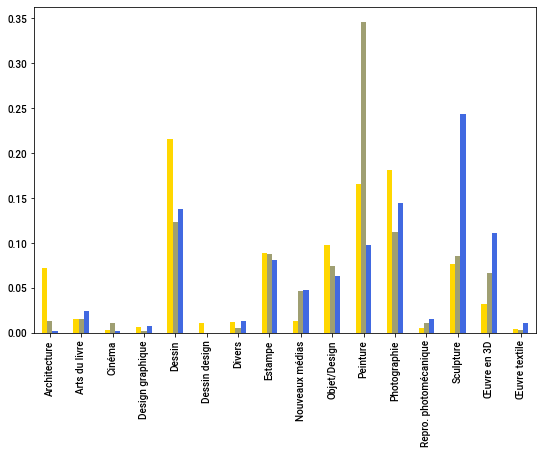

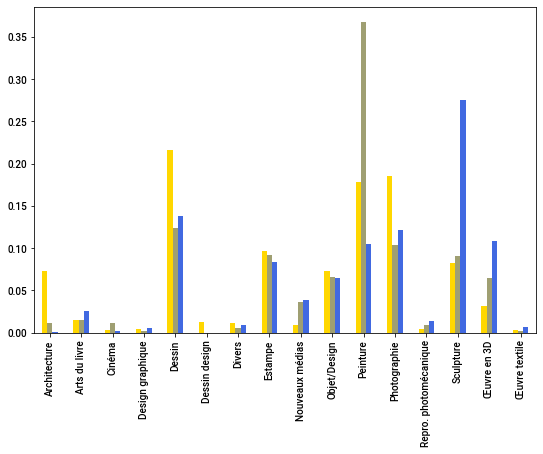

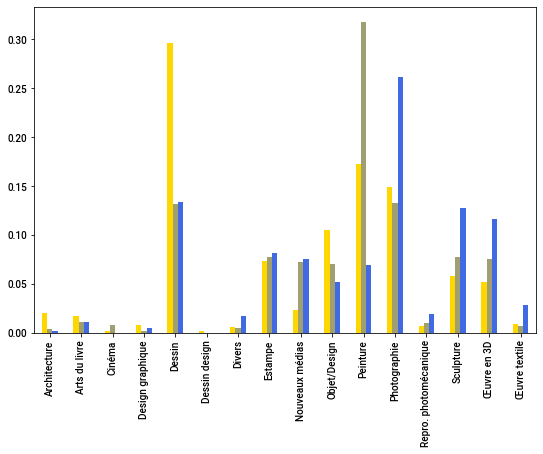

In [28]:
plot_categories_bytype(art, name="comparaison_domains.png")
plot_categories_bytype(art[art['Gender']=='masculin'], name="comparaison_domains_hommes.png")
plot_categories_bytype(art[art['Gender']=='féminin'], name="comparaison_domains_femmes.png")

In [29]:
art[(art['acquisition_mode_clean'].isin(cat_dons)) & (art['Gender']=='masculin')]['nb_expos'].mean()

1.3481156203252425

## Partie 6 : comparaison avec les achats et les commandes

In [30]:
def domains_prop_others(art, mod):
    art = art[(art['acquisition_year'] >= 1945) & (art['acquisition_year'] <= 2017)]
    overall = art.groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    overall_d = art[art['acquisition_mode_clean'] == mod].groupby('acquisition_year').count()['_id'].reindex(range(1945, 2018), fill_value=0)
    overall = pd.Series(overall_d/overall, name="Tous domaines")
    total = art.groupby(['domain', 'acquisition_year']).count()['_id']
    
    # We need the fraction of Dons in each year/domain
    f = art[art['acquisition_mode_clean'] == mod].groupby(['domain', 'acquisition_year']).count()['_id']
    ratio = f/total
    if len(ratio) > 0:
        ratio = ratio.reset_index(name='Value')
        names = sorted(list(ratio['domain'].unique()))
        all_names = sorted(list(art['domain'].dropna().unique()))
        ratio = ratio.pivot_table(index='domain', columns='acquisition_year', values='Value', aggfunc='sum')
        ratio.index = names
        ratio = ratio.reindex(columns=range(1945, 2018)).reindex(index=all_names)
        ratio = ratio.append(overall)
        mratio = np.matrix(ratio)
        
        # Then we customize the plot
        fig, ax = plt.subplots(figsize=PLOTDIM)
        im = ax.matshow(mratio, cmap=my_cm, vmin=0, vmax=1)
        #fig.set_size_inches(PLOTDIM)
        divider = make_axes_locatable(ax)
        truc = divider.append_axes("right", size="2%", pad=-4.4)
        cbar = plt.colorbar(im, cax=truc)
        cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%','100%'], fontsize=10)
        
        ax.set_xticklabels(['1950', '', '1970', '', '1990', '', '2010'], fontsize=10)
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(5, 71, 10))
        domains = list(ratio.index)
        domains = [d if not "Domaine mixte" in d else "Domaine mixte" for d in domains]
        ax.set_yticks(np.arange(0, len(domains), 1))
        ax.set_yticklabels(domains, fontsize=10)
        ax.set_aspect(5)
    plt.savefig("domains_prop_" + mod.lower() + ".png", bbox_inches='tight',format="png", dpi=300, transparent=True)
    plt.close()

In [31]:
domains_prop_others(art, mod='Achat')
domains_prop_others(art, mod='Commande')

## Partie 7 : nombres d'expositions en fonction du mode d'acquisition

In [32]:
def compte_expositions_dons(art):
    art = art[(art['acquisition_year'] >= 1945) & (art['acquisition_year'] <= 2017)]
    dons = art[art['acquisition_mode_clean'].isin(cat_dons)]
    ndons = art[~art['acquisition_mode_clean'].isin(cat_dons)]
    
    agg_dons = dons.groupby('acquisition_year').mean()['nb_expos']
    agg_ndons = ndons.groupby('acquisition_year').mean()['nb_expos']
    
    fig, ax = plt.subplots()
    agg_dons.plot(figsize=PLOTDIM, color='green', marker='.', linewidth=2, ax=ax)
    agg_ndons.plot(figsize=PLOTDIM, color='purple', marker='.', linewidth=2, ax=ax)
    ax.set_xlim(left = 1945,right = 2017)
    # ax.set_ylim(bottom = -0.01,top = 1.01)
    ax.tick_params(labelsize = 15)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(FREQYEARS))
    ax.set_xlabel('')
    # ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    plt.grid()
    plt.savefig("compte_expositions_dons.png", bbox_inches='tight',format="png", dpi=300, transparent=True)
    plt.close()

In [33]:
compte_expositions_dons(art)

## Partie 8 : les unico-donnateurs morts

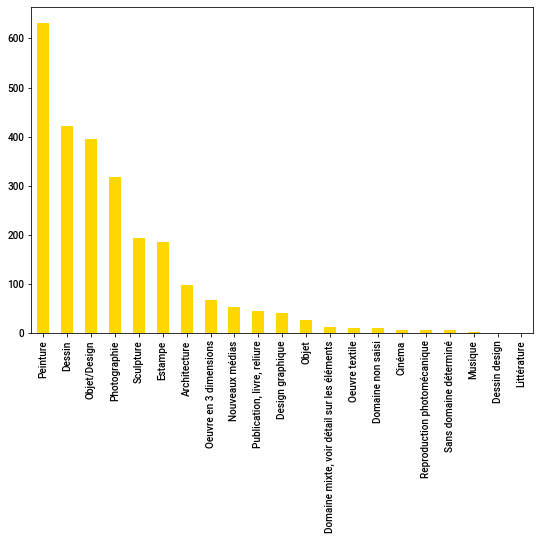

In [34]:
plot = authors[authors['unique_mode'].isin(cat_dons)]['unique_domain'].value_counts().plot.bar(figsize=PLOTDIM, cmap=my_cm, legend=None)
fig = plot.get_figure()
plt.savefig("comparaison_domains.png", bbox_inches='tight',format="png", dpi=300, transparent=True)

In [35]:
authors[authors['unique_mode'].isin(cat_dons) & (authors['Gender']=='féminin')]['unique_age'].mean()

57.4078947368421

## Partie 6 : nombre de "points de contacts" par artiste

In [ ]:
def get_contact_points(art, subset, subset_name, path):
    art = art[(art['acquisition_year'] >= 1945) & (art['acquisition_year'] <= 2017)]
    subset = subset[(subset['acquisition_year'] >= 1945) & (subset['acquisition_year'] <= 2017)]
    art_contacts = art.groupby(['authors', 'acquisition_year']).first().reset_index()
    sub_contacts = subset.groupby(['authors', 'acquisition_year']).first().reset_index()
    fig, ax = plt.subplots()
    total = sub_contacts.groupby('acquisition_year').count()['_id']
    f1 = sub_contacts[sub_contacts['Gender']=='féminin'].groupby('acquisition_year').count()
    f1 = f1['_id']
    f1 = f1.reindex(range(1945, 2018), fill_value=0)
    total = total.reindex(range(1945, 2018))
    ratio = f1/total
    ratio = ratio.reindex(range(1945, 2018))
    ratio.plot(figsize=PLOTDIM, color=color_f, marker='.', linewidth=2, ax=ax)
    ax.set_xlim(left = 1945,right = 2017)
    ax.set_ylim(bottom = -0.01,top = 1.01)
    ax.tick_params(labelsize = 15)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(FREQYEARS))
    ax.set_xlabel('')
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    plt.grid()
    plt.savefig(path, bbox_inches='tight',format="png", dpi=300, transparent=True)
    plt.close()

In [ ]:
get_contact_points(art, art, "ensemble des collections",
                      "./figures/_global/ratio_contacts.png")
get_contact_points(art, art[art['collection'].isin(fracs)], "ensemble des 18 FRAC",
                      "./figures/_fracs/ratio_contacts.png")
get_contact_points(art, art[art['collection'].isin(musées)], "ensemble des musées",
                      "./figures/_musees/ratio_contacts.png")
get_contact_points(art, art[art['collection'].isin(autres)], "autres musées",
                      "./figures/_autres/ratio_contacts.png")

In [ ]:
for museum in art['collection'].dropna().unique():
    # print("Musée en cours:", museum)
    subset = art[art['collection'] == museum]
    get_contact_points(art, subset, museum, "./figures/" + validname(museum) + "/ratio_contacts.png")
    del subset
print('Done')

## Partie 7 : age de l'artiste à la première aquisition 

In [ ]:
# Function to plot the age at acquisition (separated between hommes and femmes)
def get_age_firt_acqu(art, subset, subset_name, path):
    art = art[(art['acquisition_year'] >= 1945) & (art['acquisition_year'] <= 2017)]
    subset = subset[(subset['acquisition_year'] >= 1945) & (subset['acquisition_year'] <= 2017)]
    subset = subset[subset['is_first'] == 1]
    fig, ax = plt.subplots()
    total = subset.groupby('acquisition_year').mean()['age_at_acquisition']
    # Femmes
    f = subset[subset['Gender']=='féminin'].groupby('acquisition_year').mean()
    if len(f) > 0:
        f = f['age_at_acquisition']
        f = f.reindex(range(1945, 2018))
        f.plot(figsize=PLOTDIM, color=color_f, marker='.', linewidth=2, ax=ax)
    # Hommes
    h = subset[subset['Gender']=='masculin'].groupby('acquisition_year').mean()
    if len(h) > 0:
        h = h['age_at_acquisition']
        h = h.reindex(range(1945, 2018))
        h.plot(figsize=PLOTDIM, color=color_h, marker='.', linewidth=2, ax=ax)
    ax.set_xlim(left = 1945,right = 2017)
    ax.set_ylim(bottom = -1,top = 141)
    ax.tick_params(labelsize = 15)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(FREQYEARS))
    ax.set_xlabel('')
    plt.grid()
    plt.savefig(path, bbox_inches='tight',format="png", dpi=300, transparent=True)
    plt.close()

In [ ]:
get_age_firt_acqu(art, art, "ensemble des collections",
                      "./figures/_global/age_first_acquisition.png")
get_age_firt_acqu(art, art[art['collection'].isin(fracs)], "ensemble des 18 FRAC",
                      "./figures/_fracs/age_first_acquisition.png")
get_age_firt_acqu(art, art[art['collection'].isin(musées)], "ensemble des musées",
                      "./figures/_musees/age_first_acquisition.png")
get_age_firt_acqu(art, art[art['collection'].isin(autres)], "autres musées",
                      "./figures/_autres/age_first_acquisition.png")

In [ ]:
for museum in art['collection'].dropna().unique():
    # print("Musée en cours:", museum)
    subset = art[art['collection'] == museum]
    get_age_firt_acqu(art, subset, museum, "./figures/" + validname(museum) + "/age_first_acquisition.png")
    del subset
print('Done')

## Partie 8 : nombre d'aquisitions

In [ ]:
# Function to plot the proportion of femmes in any subset of Arworks
def get_number_acqu(art, subset, subset_name, path):
    art = art[(art['acquisition_year'] >= 1945) & (art['acquisition_year'] <= 2017)]
    subset = subset[(subset['acquisition_year'] >= 1945) & (subset['acquisition_year'] <= 2017)]
    fig, ax = plt.subplots()
    total1 = subset.groupby('acquisition_year').count()['_id']
    f1 = subset[subset['Gender']=='féminin'].groupby('acquisition_year').count()
    f2 = subset[subset['Gender']=='masculin'].groupby('acquisition_year').count()
    f1 = f1['_id']
    f2 = f2['_id']
    f1 = f1.reindex(range(1945, 2018))
    f2 = f2.reindex(range(1945, 2018))
    f1.plot(figsize=PLOTDIM, color=color_f, marker='.', linewidth=2, ax=ax)
    f2.plot(figsize=PLOTDIM, color=color_h, marker='.', linewidth=2, ax=ax)
    ax.set_xlim(left = 1945,right = 2017)
    ax.set_ylim(bottom = -10,top = 12010)
    ax.tick_params(labelsize = 15)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(FREQYEARS))
    ax.set_xlabel('')
    plt.grid()
    plt.savefig(path, bbox_inches='tight',format="png", dpi=300, transparent=True)
    plt.close()

In [ ]:
get_number_acqu(art, art, "ensemble des collections",
                      "./figures/_global/nb_acquisitions.png")
get_number_acqu(art, art[art['collection'].isin(fracs)], "ensemble des 18 FRAC",
                      "./figures/_fracs/nb_acquisitions.png")
get_number_acqu(art, art[art['collection'].isin(musées)], "ensemble des musées",
                      "./figures/_musees/nb_acquisitions.png")
get_number_acqu(art, art[art['collection'].isin(autres)], "autres musées",
                      "./figures/_autres/nb_acquisitions.png")

In [ ]:
art[(art['acquisition_year'] == 2004) & (art['authors'] == '9000000000066601')]

In [ ]:
index = [len(set(x)) > 1 for x in authors['ID artworks'].str.split('|')]
index1, index2, index3 = [], [], []
for x in authors['acquisition_year'].str.split('|'):
    if x is np.NaN: index1.append(False), index2.append(False), index3.append(False)
    else: index1.append(min([int(y) for y in x]) > 1944), index2.append(len(set(x)) > 1), index3.append(min([int(y) for y in x]) < 2010)
len(authors[[index[i] and index1[i] and index2[i] and index3[i] for i in range(len(index))]])